<a href="https://colab.research.google.com/github/BerkanDemiral/.NetCoreNotes/blob/main/LSTM_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
from google.colab import files
uploaded = files.upload()

Saving BTC-USD.csv to BTC-USD (2).csv


In [45]:
# Gerekli kütüphaneleri import etme
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from scipy.stats import levy
import random

# CSV dosyasını yükleme
df = pd.read_csv(io.BytesIO(uploaded['BTC-USD (2).csv']))

# 1. Veri setinin genel özetini yazdırma
print("Veri setinin ilk 5 satırı:")
df.head()

Veri setinin ilk 5 satırı:


,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [46]:
df[df['Volume'] == df['Volume'].max()]
df.drop(2354, inplace=True)
df[df['Volume'] == df['Volume'].max()]

,Date,Open,High,Low,Close,Adj Close,Volume
2436,2021-05-19,42944.976563,43546.117188,30681.496094,37002.441406,37002.441406,126358098747


In [47]:
print("Veri setinin genel bilgisi:")
df.info()

Veri setinin genel bilgisi:
<class 'pandas.core.frame.DataFrame'>
Index: 2746 entries, 0 to 2746
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2746 non-null   object 
 1   Open       2746 non-null   float64
 2   High       2746 non-null   float64
 3   Low        2746 non-null   float64
 4   Close      2746 non-null   float64
 5   Adj Close  2746 non-null   float64
 6   Volume     2746 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 171.6+ KB


In [48]:
print("Veri setinin özet istatistikleri:")
df.describe()

Veri setinin özet istatistikleri:


,Open,High,Low,Close,Adj Close,Volume
count,2746.000000,2746.000000,2746.000000,2746.000000,2746.000000,2.746000e+03
mean,11655.668056,11967.783037,11313.532359,11670.271243,11670.271243,1.472464e+10
std,16312.576278,16748.220259,15815.826968,16319.760675,16319.760675,1.889187e+10
min,176.897003,211.731003,171.509995,178.102997,178.102997,5.914570e+06
25%,609.055999,611.865738,606.096725,609.230499,609.230499,8.159647e+07
50%,6371.594971,6499.580078,6282.889892,6376.419922,6376.419922,5.217900e+09
75%,10706.410645,10977.989014,10405.093017,10744.442627,10744.442627,2.499411e+10
max,67549.734375,68789.625000,66382.062500,67566.828125,67566.828125,1.263581e+11


In [49]:
print("Eksik veri kontrolü:")
df.isnull().sum()

Eksik veri kontrolü:


,0
Date,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0


In [50]:
df['Date'] = pd.to_datetime(df['Date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2746 entries, 0 to 2746
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       2746 non-null   datetime64[ns]
 1   Open       2746 non-null   float64       
 2   High       2746 non-null   float64       
 3   Low        2746 non-null   float64       
 4   Close      2746 non-null   float64       
 5   Adj Close  2746 non-null   float64       
 6   Volume     2746 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 171.6 KB


In [51]:
fig1 = go.Figure()
fig1.add_trace(go.Scatter(x=df['Date'], y=df['Open'], mode='lines', name='Open', line=dict(color='blue')))
fig1.add_trace(go.Scatter(x=df['Date'], y=df['Close'], mode='lines', name='Close', line=dict(color='red')))
fig1.update_layout(
    title="Bitcoin Açılış ve Kapanış Fiyatları (Zaman Serisi)",
    xaxis_title="Tarih",
    yaxis_title="Fiyat (USD)",
    legend_title="Fiyat Türü",
    hovermode="x unified"
)
fig1.show()

fig2 = px.histogram(df, x='Volume', nbins=30, marginal='box', title="Bitcoin Günlük İşlem Hacmi Dağılımı")
fig2.update_layout(
    xaxis_title="İşlem Hacmi",
    yaxis_title="Frekans",
    hovermode="x unified"
)
fig2.show()

fig3 = px.scatter(df, x='Volume', y='Close', title="İşlem Hacmi ve Kapanış Fiyatı İlişkisi", trendline="ols")
fig3.update_layout(
    xaxis_title="İşlem Hacmi",
    yaxis_title="Kapanış Fiyatı (USD)",
    hovermode="closest"
)
fig3.show()

## Modelleme

### LSTM Algoritması

LSTM (Long Short-Term Memory), Recurrent Neural Network (RNN) mimarisine dayanan, zaman serisi verileri üzerinde uzun vadeli bağımlılıkları öğrenebilen bir modeldir. RNN'ler, önceki adımların bilgisini hafızada tutarak ardışık veri ilişkilerini öğrenir, ancak klasik RNN’ler uzun vadeli bağımlılıkları öğrenmekte zayıf kalır. Bu sorunu çözmek için LSTM, özel bir hücre yapısı kullanır.

LSTM Yapısındaki Temel Bileşenler:

    * Unutma Kapısı (Forget Gate): Hangi bilgilerin unutulacağını belirler.
    * Girdi Kapısı (Input Gate): Hangi bilgilerin güncelleneceğini belirler.
    * Çıkış Kapısı (Output Gate): Hangi bilginin sonraki adımlara aktarılacağını belirler.
    
Bu kapılar sayesinde LSTM, önemli bilgiyi uzun süre hatırlayarak zaman serilerinde daha iyi tahminler yapar.

### Cuckoo Search

Cuckoo Search Algoritması

Cuckoo Search (CS), doğal yaşamda guguk kuşlarının yumurtlama davranışından esinlenerek geliştirilmiş bir optimizasyon algoritmasıdır. CS, özellikle karmaşık problemlerin çözümünde parametre optimizasyonu için kullanılır.

Cuckoo Search Temel Mekanizması:

    * Yumurta Bırakma: Her guguk kuşu, rastgele bir yuva seçerek yumurtasını bırakır.
    * Yuva Seçimi: Rastgele seçilen bazı yumurtalar ev sahibi kuş tarafından fark edilir ve imha edilir.
    * Levy Flight: Yeni çözümler oluşturulurken Levy dağılımı kullanılarak rastgele büyük adımlar atılır.
    * En İyi Yuvayı Saklama: Her iterasyonda, mevcut en iyi çözümler saklanır.
    
Bu algoritmanın amacı, belirli bir hedef fonksiyonu en iyi şekilde optimize eden parametre setini bulmaktır.

In [52]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from scipy.stats import levy
import random
import numpy as np

In [54]:
df = df.sort_values('Date')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [ ]:
# Kapanış fiyatını hedef değişken olarak seçme (LSTM modelimiz bu değeri tahmin etmeye çalışacak)
data = df[['Close']].values

In [ ]:
# Veriyi Min-Max ölçeklendirme (LSTM'nin daha hızlı ve kararlı öğrenmesi için gerekli)
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

In [ ]:
data_scaled

array([[0.00414359],
       [0.00365546],
       [0.00321557],
       ...,
       [0.63385758],
       [0.64970558],
       [0.65616113]])

In [55]:
window_size = 60 # Bu değeri 120 yaptığımda daha uzun aralıklardaki verileri tahminlemelesi iyi oldu, 30 yaptığımda ise günlük daha kısa verileri. Ben de 60'da bıraktım.
X, y = [], [] # X-> her 60 günlük veri penceremiz, y ise bir sonraki günün kapanış fiyatı
for i in range(window_size, len(data_scaled)):
    X.append(data_scaled[i - window_size:i, 0]) # ilk 60 günün verisini alıp x'e ekledik
    y.append(data_scaled[i, 0]) # 61.günün değerini ise bağımlı değişkenimiz olacağı için y'ye ekledik.

X, y = np.array(X), np.array(y)

# LSTM giriş formatı: (num_samples, time_steps, num_features)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Veriyi eğitim ve test olarak ayırma (%80 eğitim, %20 test)
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [56]:
def build_lstm_model(window_size, units, learning_rate):
    """
    :param window_size: Girdi veri penceresinin boyutu (time steps)
    :param units: LSTM katmanındaki hücre sayısı -- LSTM'in belleğinde ne kadar veriyi tutması gerektiğini belirler Genellikle 20-200 arasında değerler girildiğini gördüm.
    :param learning_rate: Öğrenme oranı (optimizer parametresi)
    """
    model = Sequential() # Keras'da ardışık katmanlardan oluşan bir model oluşturur.
    model.add(LSTM(units=units, return_sequences=False, input_shape=(window_size, 1))) # return_sequences=False sayesinde Sadece son çıktı adımını döndürür. Çünkü tek bir değeri tahmin etmek istiyoruz (kapanış fiyatı).
    model.add(Dense(1))  # Çıkış katmanı, tek bir değer tahmin edecek
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error') # Optimizasyon algoritması olarak Adam optimizasyon algoritması kullanılır.
    return model


In [57]:
print("\n--- Aşama 1: Optimizasyon olmadan model eğitimi ---\n")
initial_units = 50
initial_learning_rate = 0.001


--- Aşama 1: Optimizasyon olmadan model eğitimi ---



In [58]:
# Modeli oluştur ve eğit
initial_model = build_lstm_model(window_size, initial_units, initial_learning_rate)
initial_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0021
Epoch 2/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 1.0021e-04
Epoch 3/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 8.6300e-05
Epoch 4/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 6.6923e-05
Epoch 5/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 6.8038e-05
Epoch 6/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 6.8371e-05
Epoch 7/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 5.4842e-05
Epoch 8/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 5.7144e-05
Epoch 9/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 6.3292e-05
Epoch 10/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 6.0138e-05
Epoch 11/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 5.5561e-05
Epoch 12/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 5.1213e-05
Epoch 13/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 4.3316e-05
Epoch 14/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 4.2307e-05
Epoch 15/20
68/68 ━━━━━━━━━━━━

In [59]:
# Test verisi için tahmin yapma
y_pred_scaled = initial_model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step


In [62]:
rmse_initial = np.sqrt(mean_squared_error(y_test_original, y_pred))
r2_initial = r2_score(y_test_original, y_pred)
loss_initial = initial_model.evaluate(X_test, y_test, verbose=0)
mae_initial = mean_absolute_error(y_test_original, y_pred)
mse_initial = mean_squared_error(y_test_original, y_pred)
mape_initial = np.mean(np.abs((y_test_original - y_pred) / y_test_original)) * 100

In [63]:
direction_real = np.sign(y_test_original[1:] - y_test_original[:-1])
direction_pred = np.sign(y_pred[1:] - y_pred[:-1])

In [65]:
print(f"RMSE (Optimizasyonsuz): {rmse_initial:.4f}")
print(f"R^2 Skoru (Optimizasyonsuz): {r2_initial:.4f}")
print(f"Loss (Optimizasyonsuz): {loss_initial:.4f}")
print(f"MAE (Optimizasyonsuz): {mae_initial:.4f}")
print(f"MSE (Optimizasyonsuz): {mse_initial:.4f}")
print(f"MAPE (Optimizasyonsuz): {mape_initial:.2f}%")

RMSE (Optimizasyonsuz): 6182.3540
R^2 Skoru (Optimizasyonsuz): 0.8032
Loss (Optimizasyonsuz): 0.0084
MAE (Optimizasyonsuz): 5227.3511
MSE (Optimizasyonsuz): 38221501.0879
MAPE (Optimizasyonsuz): 11.42%


In [66]:
def levy_flight(Lambda):
    """
    Levy uçuş adımı oluşturur.
    :param Lambda: Levy dağılımının parametresi. Genellikle 1.5 civarında değerler kullanılır. Bu ne çok uzun bir sıçrama yani test ne de çok uzun bir sıçrama olacağını gösterir.
    :return: Levy uçuş adımı
    """
    sigma = (np.math.gamma(1 + Lambda) * np.sin(np.pi * Lambda / 2) /
             (np.math.gamma((1 + Lambda) / 2) * Lambda * 2 ** ((Lambda - 1) / 2))) ** (1 / Lambda)
    u = np.random.normal(0, sigma, 1) # sigmaya bağlı random bir u
    v = np.random.normal(0, 1, 1) # standart sapması 1 olan random bir v oluşturulur
    step = u / abs(v) ** (1 / Lambda) # Bu adım, mevcut çözümün üzerine eklenerek yeni bir çözüm bulunur.
    return step[0]

**Örnek:**

Lambda, bu dağılımın parametresidir ve genellikle 1.5 civarında bir değer olarak alınır.
sigma, bu dağılımın standart sapmasıdır. Bu, rastgele sayılar üretirken ne kadar geniş bir dağılım olacağını belirler.

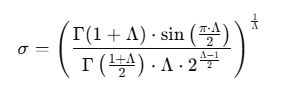


Adım 1: Gamma Fonksiyonlarının Hesaplanması

Gamma fonksiyonu, bir sayının faktöriyelini genelleyen bir fonksiyondur. Örneğin:
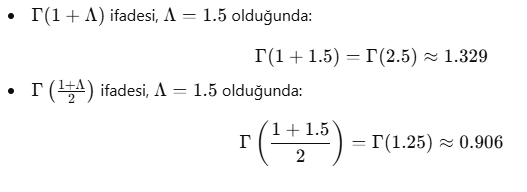

Adım 2: Sinüs Fonksiyonunun Hesaplanması

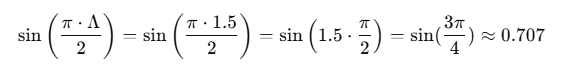

Adım 3: 2’nin Üs Alma İşlemi

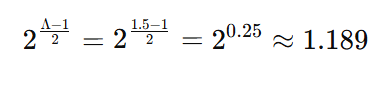

Adım 4: Formülün İçindeki Çarpımlar

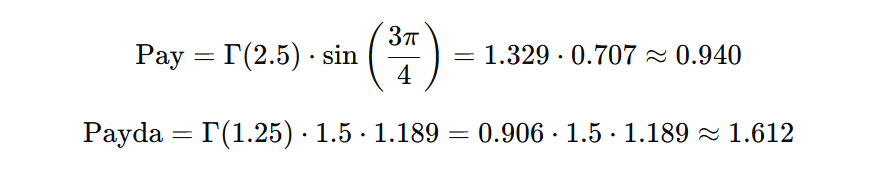

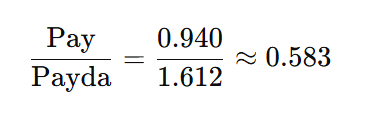

Adım 6: Üs Alma İşlemi

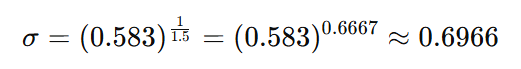


Lambda = 1.5
`Bu durumda, sigma yaklaşık olarak 0.6966 gibi bir değer çıkar`
`Sonuç olarak sigma yaklaşık 0.6966 bulunur (bu değer rastgele adımlar üretirken kullanılır).`



In [68]:
def cuckoo_search(n, max_iter, window_size):
    """
    Cuckoo Search algoritması ile LSTM hiperparametre optimizasyonu.
    :param n: Toplam yuva sayısı (çözüm sayısı)
    :param max_iter: Maksimum iterasyon sayısı
    :param window_size: LSTM modelinin girdi penceresi boyutu
    """
    # İlk çözümleri (yuvaları) rastgele oluştur
    nests = [{'units': random.randint(20, 100),
              'learning_rate': random.uniform(0.001, 0.01),
              'loss': float('inf')} for _ in range(n)]

    best_nest = nests[0]
    best_losses = []  # Her iterasyondaki en iyi loss değerini saklamak için liste

    for iteration in range(max_iter):
        for nest in nests:
            # Rastgele bir Levy uçuş adımı oluştur ve yeni bir çözüm elde et
            step_size = levy_flight(1.5)
            new_units = int(nest['units'] + step_size * random.randint(-10, 10))
            new_lr = nest['learning_rate'] + step_size * random.uniform(-0.001, 0.001)
            new_units = max(10, min(200, new_units))  # Hücre sayısını sınırla
            new_lr = max(0.0001, min(0.1, new_lr))  # Öğrenme oranını sınırla

            # Yeni çözümle bir LSTM modeli oluştur ve eğit
            model = build_lstm_model(window_size, new_units, new_lr)
            model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)
            loss = model.evaluate(X_test, y_test, verbose=0)

            # Eğer yeni çözüm daha iyi ise güncelle
            if loss < nest['loss']:
                nest['units'] = new_units
                nest['learning_rate'] = new_lr
                nest['loss'] = loss

            # En iyi yuvayı güncelle
            if loss < best_nest['loss']:
                best_nest = nest

        best_losses.append(best_nest['loss'])
        print(f"Iterasyon {iteration + 1}/{max_iter}, En iyi loss: {best_nest['loss']:.4f}")

    # Loss değerlerini görselleştir
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_iter + 1), best_losses, marker='o')
    plt.title("Cuckoo Search İterasyonlarına Göre En İyi Loss Değerleri")
    plt.xlabel("İterasyon")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()

    return best_nest


--- Aşama 2: Cuckoo Search ile parametre optimizasyonu ---



<ipython-input-66-6d913cb44aeb>:7: DeprecationWarning:

`np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`

<ipython-input-66-6d913cb44aeb>:8: DeprecationWarning:

`np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Iterasyon 1/10, En iyi loss: 0.0029
Iterasyon 2/10, En iyi loss: 0.0024
Iterasyon 3/10, En iyi loss: 0.0008
Iterasyon 4/10, En iyi loss: 0.0008
Iterasyon 5/10, En iyi loss: 0.0008
Iterasyon 6/10, En iyi loss: 0.0008
Iterasyon 7/10, En iyi loss: 0.0008
Iterasyon 8/10, En iyi loss: 0.0008
Iterasyon 9/10, En iyi loss: 0.0008
Iterasyon 10/10, En iyi loss: 0.0008


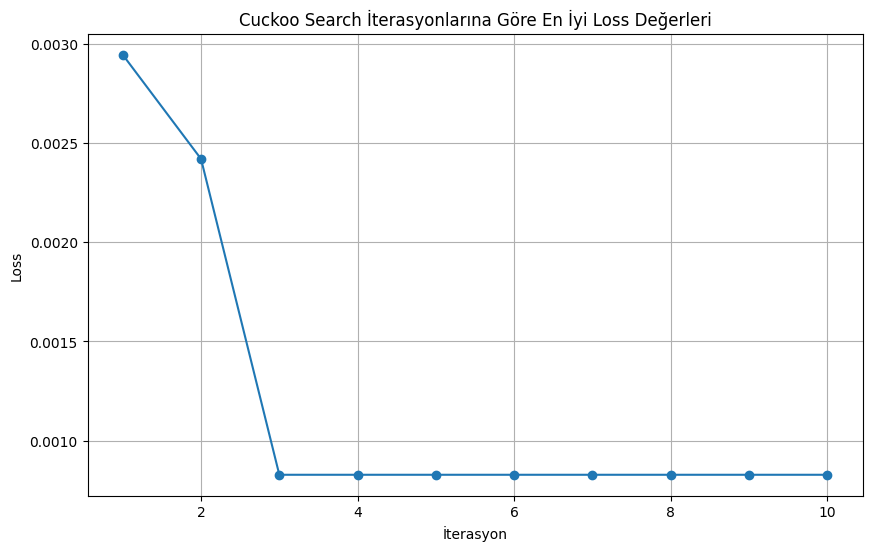

En iyi hiperparametreler:
LSTM hücre sayısı: 47
Öğrenme oranı: 0.009815896930775904
En düşük loss: 0.000828761316370219
Epoch 1/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0013
Epoch 2/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 5.0818e-05
Epoch 3/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 4.3982e-05
Epoch 4/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 4.4288e-05
Epoch 5/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 4.2168e-05
Epoch 6/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 3.1221e-05
Epoch 7/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 3.2192e-05
Epoch 8/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 2.9574e-05
Epoch 9/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 3.7662e-05
Epoch 10/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 3.3019e-05
Epoch 11/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 3.1325e-05
Epoch 12/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 3.6440e-05
Epoch 13/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s

In [69]:
# 5. Cuckoo Search ile LSTM Hiperparametre Optimizasyonu
print("\n--- Aşama 2: Cuckoo Search ile parametre optimizasyonu ---\n")
n = 5  # Toplam yuva (çözüm) sayısı
max_iter = 10  # Maksimum iterasyon sayısı

best_params = cuckoo_search(n, max_iter, window_size)
print("En iyi hiperparametreler:")
print(f"LSTM hücre sayısı: {best_params['units']}")
print(f"Öğrenme oranı: {best_params['learning_rate']}")
print(f"En düşük loss: {best_params['loss']}")

# En iyi hiperparametrelerle model oluşturma ve eğitme
final_model = build_lstm_model(window_size, best_params['units'], best_params['learning_rate'])
final_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# Test verisi için tahmin yapma
y_pred_scaled_final = final_model.predict(X_test)
y_pred_final = scaler.inverse_transform(y_pred_scaled_final.reshape(-1, 1))

rmse_final = np.sqrt(mean_squared_error(y_test_original, y_pred_final))
r2_final = r2_score(y_test_original, y_pred_final)
loss_final = final_model.evaluate(X_test, y_test, verbose=0)
mae_final = mean_absolute_error(y_test_original, y_pred_final)
mse_final = mean_squared_error(y_test_original, y_pred_final)
mape_final = np.mean(np.abs((y_test_original - y_pred_final) / y_test_original)) * 100

print(f"RMSE (Optimizasyonlu): {rmse_final:.4f}")
print(f"R^2 Skoru (Optimizasyonlu): {r2_final:.4f}")
print(f"Loss (Optimizasyonlu): {loss_final:.4f}")
print(f"MAE (Optimizasyonlu): {mae_final:.4f}")
print(f"MSE (Optimizasyonlu): {mse_final:.4f}")
print(f"MAPE (Optimizasyonlu): {mape_final:.2f}%")